# PushShift Reddit Web Scraping

In [102]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns


import requests
from bs4 import BeautifulSoup    
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
from collections import Counter
import re


from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)


pd.options.display.max_colwidth = 400
%config InlineBackend.figure_format = 'retina'

# Modeling

In [5]:
df = pd.read_csv('big_df.csv')

In [6]:
df.shape

(21472, 7)

In [7]:
df['subreddit'] = df['subreddit'].apply(lambda x: 1 if x == 'UpliftingNews' else 0)

In [8]:
df.tail()

,datetime,title,score,num_comments,subreddit,title_len,title_word_count
21467,2012-06-04 23:12:38,state of the subreddit address,527,41,1,31,5
21468,2012-06-02 15:06:36,after 13 year of determination dusty born with down syndrome earns a black belt in kung fu,124,13,1,95,17
21469,2012-05-26 12:57:01,special education student becomes prom king,44,10,1,43,6
21470,2012-05-24 14:59:58,uplifting indeed many thanks to this awesome little sub,59,14,1,57,10
21471,2012-05-23 01:33:02,girlfriend marries husband after he get in an accident sustains a serious brain injury i don t even care if this is religious propaganda it s beautiful,29,13,1,155,25


In [131]:
X = df['title']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
import sys
sys.getsizeof(X_train)

2107180

In [118]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
pipe = Pipeline([
    ('cvec', CountVectorizer()), 
    ('nb', MultinomialNB())
])
pipe_params = {
    'cvec__max_features' : [2000, 4000, 8000, 16000],
    'cvec__min_df': [2, 3,],
    'cvec__max_df': [.99, .95],
    'cvec__stop_words' : [None, 'english'],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'nb__alpha': [1, 1e-1, 1e-2]
}

gs = GridSearchCV(pipe, pipe_params, cv=10, verbose=1, n_jobs=8, return_train_score=True )
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   18.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   43.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 1920 out of 1920 | elapsed:  3.2min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=8,
             param_grid={'cvec__max_df': [0.99, 0.95],
                         'cvec__max_features': [2000, 4000, 8000, 16000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'nb__alpha': [1, 0.1, 0.01]},
             return_train_score=True, verbose=1)

In [119]:
gs.best_params_

{'cvec__max_df': 0.99,
 'cvec__max_features': 16000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'nb__alpha': 1}

In [120]:
gs.best_score_

0.8312949129214868

In [121]:
gs.score(X_test, y_test)

0.8211967259384703

In [144]:
# Get predictions
pred = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(tn, fp, fn, tp)

2869 699 568 2950


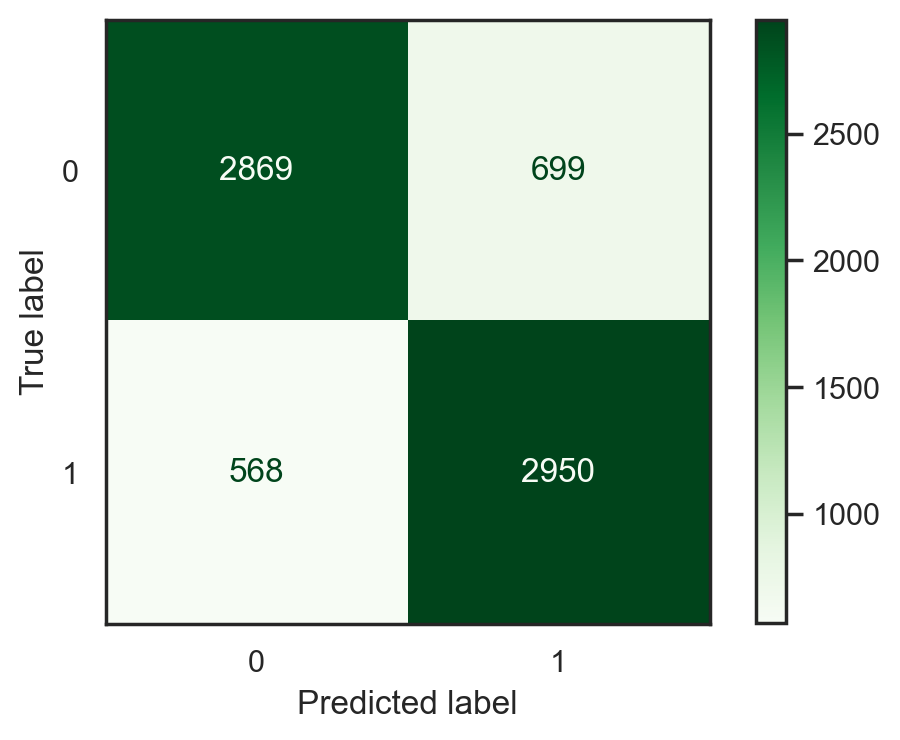

In [143]:
# View confusion matrix
sns.set_style("white")
plot_confusion_matrix(gs, X_test, y_test, cmap="Greens", values_format='d')
%config InlineBackend.figure_format = 'retina'

In [145]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%')

print()
print()
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  82.1 %
Precision:  80.8 %


Sensitivity:  83.9 %
Specificity:  80.4 %


In [114]:
# Instantiate the transformer.
tvec = TfidfVectorizer()



# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

tvec_pipe = Pipeline([
    ('tvec' , TfidfVectorizer()),
    ('nb', MultinomialNB())
])


pipe_params_tvec = {
    'tvec__max_features' : [2000, 4000, 8000, 16000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__use_idf': (True, False),
    'tvec__norm': ('l1', 'l2'),
    'tvec__ngram_range' : [(1,1), (1,2)],
    'nb__alpha': [1, 1e-1, 1e-2]
}

# Instantiate GridSearchCV.
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(tvec_pipe,
                      pipe_params_tvec,
                      cv = 10,
                      verbose=1,
                      n_jobs=8)

# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

gs_tvec.best_params_

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   33.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   59.9s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 1920 out of 1920 | elapsed:  2.4min finished


{'nb__alpha': 0.1,
 'tvec__max_features': 16000,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__stop_words': None,
 'tvec__use_idf': False}

In [128]:
gs_tvec.best_score_

0.8334502015675002

In [129]:
gs_tvec.score(X_test, y_test)

0.8183742591024555

In [140]:
# Get predictions
pred = gs_tvec.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(tn, fp, fn, tp)

2821 747 540 2978


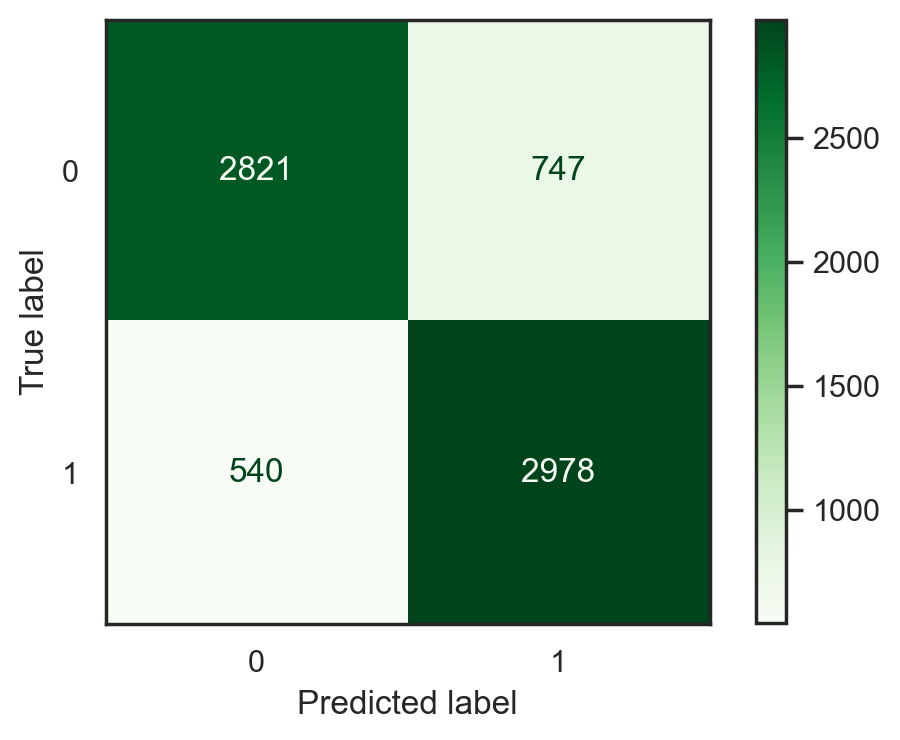

In [141]:
# View confusion matrix
sns.set_style("white")
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap="Greens", values_format='d')
%config InlineBackend.figure_format = 'retina'

In [142]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%')

print()
print()
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  81.8 %
Precision:  79.9 %


Sensitivity:  84.7 %
Specificity:  79.1 %


In [116]:
# Write a function to get the compound sentiment scores for a post

sia = SentimentIntensityAnalyzer()

def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']
df['sentiment'] = df['title'].apply(get_compound_sentiment)

get_text_data = FunctionTransformer(lambda x: x['title'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['title_word_count', 'sentiment', 'score', 'num_comments']], validate = False)

In [159]:
X = df[['title', 'title_word_count','sentiment', 'score', 'num_comments']]
y = df['subreddit']

np.random.seed(824)

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [118]:
pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression())
])
params = {

    'features__text_features__cvec__max_df':[.99, .98] , 
    'features__text_features__cvec__max_features':[10000, 50000, 150000], 
    'features__text_features__cvec__min_df': [2, 3], 
    'features__text_features__cvec__ngram_range': [(1,1), (1,2)],
    'features__text_features__cvec__stop_words' : [None, 'english'],
    'logreg__penalty' : ['l2'],
    'logreg__max_iter': [1000, 5000]
}

In [120]:
gs_textnum = GridSearchCV(pipe, params, cv=5, verbose=1, n_jobs=8)

gs_textnum.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   32.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 480 out of 480 | elapsed:  1.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numeric_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7fec15a82e50>)),
                                                                                        ('ss',
                                                                                         StandardScaler())])),
                                                                       ('text_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7fec15a41940>)),
                              

In [121]:
print(gs_textnum.score(X_train, y_train))

0.9884500745156483


In [92]:
print(gs_textnum.score(X_test, y_test))

0.8396050670640834


In [122]:
gs_textnum.best_params_

{'features__text_features__cvec__max_df': 0.99,
 'features__text_features__cvec__max_features': 50000,
 'features__text_features__cvec__min_df': 2,
 'features__text_features__cvec__ngram_range': (1, 2),
 'features__text_features__cvec__stop_words': None,
 'logreg__max_iter': 1000,
 'logreg__penalty': 'l2'}

In [165]:
features = gs_textnum.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()
coefficients = gs_textnum.best_estimator_.named_steps['logreg'].coef_[0]

gs_textnum_coef = pd.DataFrame({'features': ['title_word_count', 'sentiment', 'score', 'num_comments']+ features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients]
             })
gs_textnum_coef.sort_values(by='exp_coef').head(30)

,features,coef,exp_coef
25421,say,-1.910448,0.148014
28362,tell,-1.745447,0.174567
23084,porn,-1.683083,0.185800
23033,poop,-1.624445,0.197021
19617,naked,-1.571741,0.207683
1059,admits,-1.548580,0.212550
6395,claim,-1.528386,0.216885
16421,jesus,-1.524352,0.217762
32295,warns,-1.489287,0.225533
25129,russia,-1.443755,0.236040


In [155]:
features = gs_textnum.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()
coefficients = gs_textnum.best_estimator_.named_steps['logreg'].coef_[0]

gs_textnum_coef = pd.DataFrame({'Features': ['title_word_count', 'sentiment', 'score', 'num_comments']+ features, 
              
              'Coefficient': [round(np.exp(coef), 3) for coef in coefficients]
             })
gs_textnum_coef.sort_values(by='Coefficient').head(30)

,Features,Coefficient
25421,say,0.148
28362,tell,0.175
23084,porn,0.186
23033,poop,0.197
19617,naked,0.208
1059,admits,0.213
6395,claim,0.217
16421,jesus,0.218
32295,warns,0.226
25129,russia,0.236


In [150]:
gs_textnum_coef.sort_values(by='exp_coef').head(30)

,features,coef,exp_coef
25421,say,-1.910448,0.148014
28362,tell,-1.745447,0.174567
23084,porn,-1.683083,0.185800
23033,poop,-1.624445,0.197021
19617,naked,-1.571741,0.207683
1059,admits,-1.548580,0.212550
6395,claim,-1.528386,0.216885
16421,jesus,-1.524352,0.217762
32295,warns,-1.489287,0.225533
25129,russia,-1.443755,0.236040


In [123]:
# Get predictions
pred = gs_textnum.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(tn, fp, fn, tp)

2303 381 480 2204


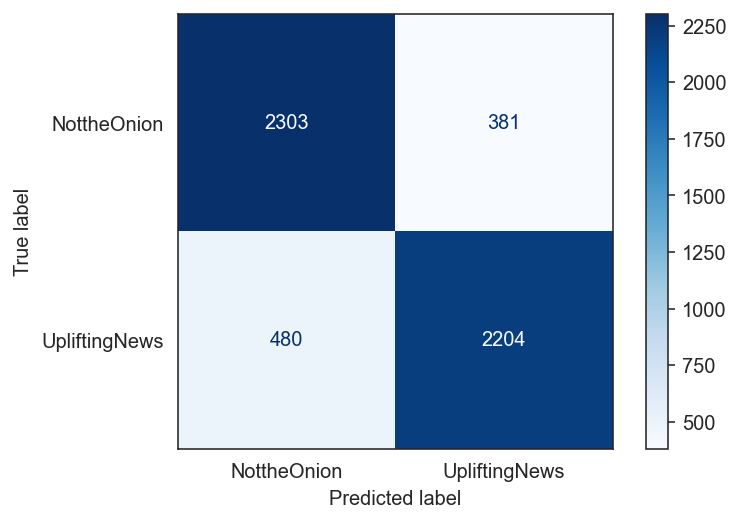

In [164]:
# View confusion matrix
sns.set_style("white")
labels = ['NottheOnion', 'UpliftingNews']
plot_confusion_matrix(gs_textnum, X_test, y_test, display_labels=labels, cmap="Blues", values_format='d')
%config InlineBackend.figure_format = 'retina'

In [126]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%')

print()
print()
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  84.0 %
Precision:  85.3 %


Sensitivity:  82.1 %
Specificity:  85.8 %


In [170]:
X = df['title']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
import sys



cvecrf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier()),
])

cvecrf_params = {
    'cvec__max_features' : [10000, 50000, 150000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.99, .98],
    'cvec__stop_words' : [None, 'english'],
    'cvec__ngram_range' : [(1,1), (1,2)],
    
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 1, 3]
}
gs_cvecrf = GridSearchCV(cvecrf_pipe,
                      cvecrf_params,
                      cv = 10,
                      verbose=1,
                      n_jobs=8)

In [171]:
gs_cvecrf.fit(X_train, y_train)

gs_cvecrf.best_params_

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 10.9min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 17.5min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 24.7min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 34.2min
[Parallel(n_jobs=8)]: Done 2880 out of 2880 | elapsed: 40.6min finished


{'cvec__max_df': 0.98,
 'cvec__max_features': 150000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'rf__max_depth': None,
 'rf__n_estimators': 200}

In [172]:
print(gs_cvecrf.score(X_train, y_train))
print(gs_cvecrf.score(X_test, y_test))
print(gs_cvecrf.best_params_)

0.9987487835395523
0.7898673440587073
{'cvec__max_df': 0.98, 'cvec__max_features': 150000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'rf__max_depth': None, 'rf__n_estimators': 200}


In [173]:
# Get predictions
pred = gs_cvecrf.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(tn, fp, fn, tp)

2836 732 757 2761


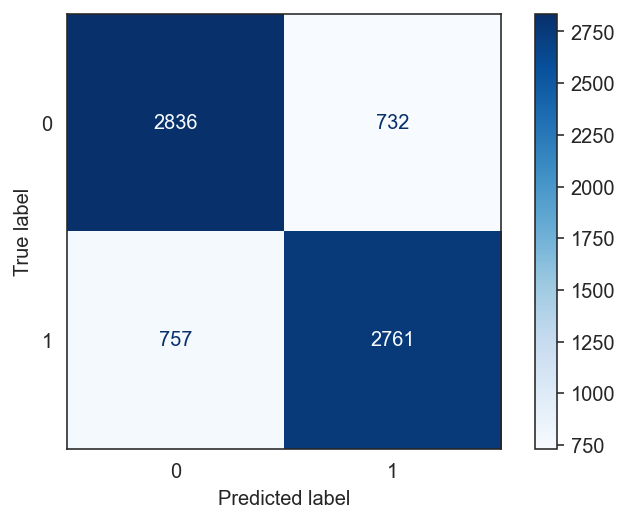

In [174]:
# View confusion matrix
sns.set_style("white")
plot_confusion_matrix(gs_cvecrf, X_test, y_test, cmap="Blues", values_format='d')
%config InlineBackend.figure_format = 'retina'

In [175]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%')

print()
print()
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  79.0 %
Precision:  79.0 %


Sensitivity:  78.5 %
Specificity:  79.5 %


In [167]:
X = df['title']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
import sys



rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier()),
])

# define parameter grid for SVC model
rf_params = {
    'tvec__max_features' : [2000, 10000, 16000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__use_idf': (True, False),
    'tvec__norm': ('l1', 'l2'),
    'tvec__ngram_range' : [(1,1), (1,2)],
    
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 1, 3]
}

gs_rf = GridSearchCV(rf_pipe,
                      rf_params,
                      cv = 10,
                      verbose=1,
                      n_jobs=8)

In [168]:
gs_rf.fit(X_train, y_train)

gs_rf.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.4s
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 11.9min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 14.4min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 15.3min
[Parallel(n_jobs=8)]: Done 1440 out of 1440 | elapsed: 15.7min finished


{'rf__max_depth': None,
 'rf__n_estimators': 200,
 'tvec__max_features': 16000,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__stop_words': None,
 'tvec__use_idf': False}

In [169]:
print(gs_rf.score(X_train, y_train))
print(gs_rf.score(X_test, y_test))
print(gs_rf.best_params_)

0.9987487835395523
0.7870448772226927
{'rf__max_depth': None, 'rf__n_estimators': 200, 'tvec__max_features': 16000, 'tvec__ngram_range': (1, 1), 'tvec__norm': 'l2', 'tvec__stop_words': None, 'tvec__use_idf': False}


In [113]:
# Get predictions
pred = gs_rf.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(tn, fp, fn, tp)

2742 826 675 2843


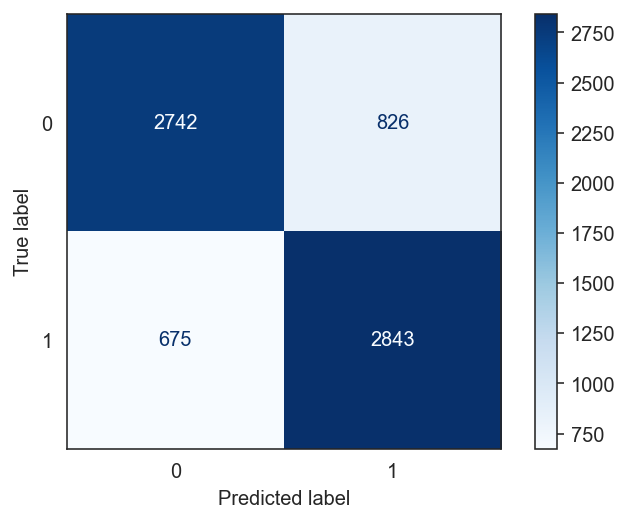

In [114]:
# View confusion matrix
sns.set_style("white")
plot_confusion_matrix(gs_rf, X_test, y_test, cmap="Blues", values_format='d')
%config InlineBackend.figure_format = 'retina'

In [115]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%')

print()
print()
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  78.8 %
Precision:  77.5 %


Sensitivity:  80.8 %
Specificity:  76.8 %


In [132]:
# Instantiate the transformer.
tvec = TfidfVectorizer()



# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

tveclr_pipe = Pipeline([
    ('tvec' , TfidfVectorizer()),
    ('logreg', LogisticRegression())
])


pipe_params_tveclr = {
    'tvec__max_features' : [2000, 4000, 8000, 16000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__use_idf': (True, False),
    'tvec__norm': ('l1', 'l2'),
    'tvec__ngram_range' : [(1,1), (1,2)],
    'logreg__penalty' : ['l2'],
    'logreg__C': [0.1, 1, 10],
    'logreg__max_iter': [1000, 5000]
}

# Instantiate GridSearchCV.
# Instantiate GridSearchCV.
gs_tveclr = GridSearchCV(tveclr_pipe,
                      pipe_params_tveclr,
                      cv = 10,
                      verbose=1,
                      n_jobs=8)

# Fit GridSearch to training data.
gs_tveclr.fit(X_train, y_train)

gs_tveclr.best_params_

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   35.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 3840 out of 3840 | elapsed:  6.0min finished


{'logreg__C': 10,
 'logreg__max_iter': 1000,
 'logreg__penalty': 'l2',
 'tvec__max_features': 16000,
 'tvec__ngram_range': (1, 2),
 'tvec__norm': 'l2',
 'tvec__stop_words': None,
 'tvec__use_idf': False}

In [133]:
print(gs_tveclr.score(X_train, y_train))
print(gs_tveclr.score(X_test, y_test))


0.9680939802585847
0.8199266158622636


In [134]:
# Get predictions
pred = gs_tveclr.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(tn, fp, fn, tp)

2909 659 617 2901


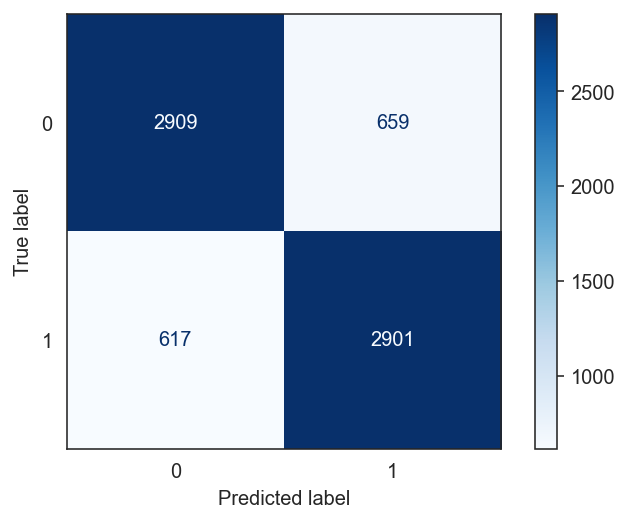

In [140]:
# View confusion matrix
sns.set_style("white")
plot_confusion_matrix(gs_tveclr, X_test, y_test, cmap="Blues", values_format='d')
%config InlineBackend.figure_format = 'retina'

In [136]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%')

print()
print()
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  82.0 %
Precision:  81.5 %


Sensitivity:  82.5 %
Specificity:  81.5 %


In [144]:



# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

cveclr_pipe = Pipeline([
    ('cvec' , CountVectorizer()),
    ('logreg', LogisticRegression())
])


pipe_params_cveclr = {
    'cvec__max_features' : [10000, 50000, 150000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.99, .98],
    'cvec__stop_words' : [None, 'english'],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'logreg__penalty' : ['l2'],
    'logreg__C': [0.1, 1, 10],
    'logreg__max_iter': [1000, 5000]
}

# Instantiate GridSearchCV.
# Instantiate GridSearchCV.
gs_cveclr = GridSearchCV(cveclr_pipe,
                      pipe_params_cveclr,
                      cv = 10,
                      verbose=1,
                      n_jobs=8)

# Fit GridSearch to training data.
gs_cveclr.fit(X_train, y_train)

gs_cveclr.best_params_

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   51.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done 2880 out of 2880 | elapsed:  5.8min finished


{'cvec__max_df': 0.99,
 'cvec__max_features': 50000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'logreg__C': 1,
 'logreg__max_iter': 1000,
 'logreg__penalty': 'l2'}

In [145]:
print(gs_cveclr.score(X_train, y_train))
print(gs_cveclr.score(X_test, y_test))


0.9895036841373558
0.8241603161162856


In [146]:
# Get predictions
pred = gs_cveclr.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(tn, fp, fn, tp)

2995 573 673 2845


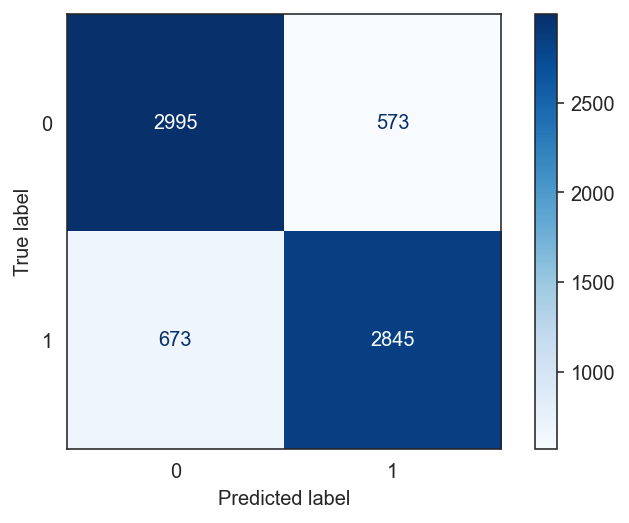

In [147]:
# View confusion matrix
sns.set_style("white")
plot_confusion_matrix(gs_cveclr, X_test, y_test, cmap="Blues", values_format='d')
%config InlineBackend.figure_format = 'retina'

In [148]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%')

print()
print()
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  82.4 %
Precision:  83.2 %


Sensitivity:  80.9 %
Specificity:  83.9 %
